# Introduction

In this notebook, I'll attempt to make a sentiment prediction on movie reviews and tweets. We'll start by importing our libraries and loading our dataset.

# Importing Libraries

In [1]:
import csv
import numpy as np

# Loading & Visualizing Dataset

In [111]:
text_data,labels=[],[]
with open('sentiment-dataset/imdb-dataset/train.csv','r') as traincsv:
    reader=csv.DictReader(traincsv)
    for row in reader:
        text_data.append(row["\ufefftext"])
        labels.append(int(row['label']))
    

In [112]:
print("first few labels",labels[:5])
print("first two reviews",text_data[:2])


first few labels [0, 0, 0, 0, 1]
first two reviews ['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', "When I put this movie in my DVD player, and sat down with a coke and 

Let's see if our labels are balanced

In [113]:
print("Mean of labels is:", np.mean(labels))

Mean of labels is: 0.499525


It's balanced enough, since if it was more leaning towards 1 it will have a score higher than 0.5

For our model to work well, we'll have to pre-process the data. So we have to:
1. remove punctuation
2. regularize data to lower case
3. remove HTML tags. Ex: `<br></br>`
4. Remove stopwords like "and", "the", "at"
5. Lemmatization of text by turning words like "reading", "reads" to same word "read"

The punctuation and HTML tags will confuse the model and add embeddings for things that shouldn't be consequential to the sentiment. Regularizing data to lower case will also help us embed the text.

# Pre-processing

In [5]:
from string import punctuation
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

stemmer=SnowballStemmer("english")
lemmatizer=WordNetLemmatizer()

stop_words=set(stopwords.words('english'))
print("Punctuation is :" ,punctuation)
print("Stop words are: ", stop_words)

# to remove HTML tags, we'll use regex
regex_cleaner=re.compile('<.*?>')
def clean(text_to_clean:list):
    clean_text=[]
    for row_text in text_to_clean:
        # lowercase
        row_text=row_text.lower()
        #HTML tags
        row_text=re.sub(regex_cleaner,' ',row_text)
        row_text=re.sub('https://.*','',row_text) 
        # removing punctuation
        row_text=''.join([c for c in row_text if c not in punctuation])
        # stop words "the", "at"...
        row_text=' '.join([word for word in row_text.split() if word not in (stop_words)])
        # lemmatizing the data and removing small words that can be individual letters
        row_text=' '.join([lemmatizer.lemmatize(word) for word in row_text.split(" ")])
        clean_text.append(row_text)
    return clean_text

clean_text=clean(text_data)
        


Punctuation is : !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Stop words are:  {'or', 'up', 'her', 'from', 'am', 'its', 'we', "mightn't", 'ma', 'has', 'with', 'before', 's', "weren't", 'at', "you'll", 'all', 'between', 'my', 'where', 'through', 'after', 'it', "you'd", 'no', 'didn', 'as', 'needn', "haven't", 'to', 'itself', 'those', 'mightn', 'other', 'should', 'were', 'there', 'an', 'have', 'a', 'isn', "shan't", 'had', 'these', 'until', 'ourselves', 'won', 'by', "don't", 'too', 'now', 'does', 'hasn', 'being', "aren't", 'can', "didn't", 'some', 'be', 'been', 'll', 'each', 'against', 'hadn', "mustn't", 'his', 'for', 'herself', 'very', 'me', 'having', 'just', 'haven', "needn't", 'than', 'weren', 'because', 'him', 'in', 't', 'shan', 'himself', 'under', 'are', 'and', "isn't", 'mustn', 'about', 'did', "couldn't", "she's", 'couldn', 'will', 'd', 'what', 'but', 'whom', 'theirs', 'while', 'ain', 'how', 'into', 'he', 'shouldn', 'wouldn', 'the', 'same', 'of', 'nor', "hasn't", 'ours', 'i', 'myself', "wouldn't

Now let's compare between the two lists of texts.

In [6]:
print("Row in raw text\n",text_data[0])
print("Row in clean data\n",clean_text[0])

Row in raw text
 I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.
Row in clean data
 grew b 1965 watching loving thunderbird mate school watched played thunderbird school lun

The pre-processing stage went well (good enough). Now it's time to encode words.

## Encoding Words

### Naive Approach

To train our model, it will need for the words to be encoded to numbers. So we'll make our own embedding layer. 

In [7]:
# will start by making a list of all the words
all_text=' '.join(clean_text)
print(all_text[:500])

grew b 1965 watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting 5 became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utte


In [8]:
# now we'll split all into words
words_list=all_text.split(' ')
print(words_list[:100])

['grew', 'b', '1965', 'watching', 'loving', 'thunderbird', 'mate', 'school', 'watched', 'played', 'thunderbird', 'school', 'lunch', 'school', 'wanted', 'virgil', 'scott', 'one', 'wanted', 'alan', 'counting', '5', 'became', 'art', 'form', 'took', 'child', 'see', 'movie', 'hoping', 'would', 'get', 'glimpse', 'loved', 'child', 'bitterly', 'disappointing', 'high', 'point', 'snappy', 'theme', 'tune', 'could', 'compare', 'original', 'score', 'thunderbird', 'thankfully', 'early', 'saturday', 'morning', 'one', 'television', 'channel', 'still', 'play', 'rerun', 'series', 'gerry', 'anderson', 'wife', 'created', 'jonatha', 'frakes', 'hand', 'director', 'chair', 'version', 'completely', 'hopeless', 'waste', 'film', 'utter', 'rubbish', 'cgi', 'remake', 'may', 'acceptable', 'replacing', 'marionette', 'homo', 'sapiens', 'subsp', 'sapiens', 'huge', 'error', 'judgment', 'put', 'movie', 'dvd', 'player', 'sat', 'coke', 'chip', 'expectation', 'hoping', 'movie', 'would', 'contain', 'strongpoints']


In [9]:
from collections import Counter

counts = Counter(words_list)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
print(len(vocab_to_int))

137585


In [10]:
# map text to ints
text_ints=[]
for row in clean_text:
    text_ints.append([vocab_to_int[word] for word in row.split(' ')])

In [11]:
print(text_ints[0])

[1957, 777, 7631, 65, 1689, 6927, 2671, 267, 194, 162, 6927, 267, 5289, 267, 357, 14447, 932, 3, 357, 1661, 7315, 535, 751, 340, 608, 440, 168, 13, 1, 1250, 11, 10, 2228, 317, 168, 11065, 1196, 230, 86, 7150, 424, 1692, 28, 1312, 115, 430, 6927, 2233, 307, 2105, 1637, 3, 576, 903, 53, 70, 4006, 114, 11272, 2054, 219, 925, 60408, 23308, 272, 63, 2438, 201, 238, 4170, 331, 2, 1818, 1681, 1472, 783, 109, 3065, 8545, 24705, 14448, 26301, 60409, 26301, 513, 2532, 4888]


### Using Word2Vec

As you can see we ended up with 100,000+ activations. To work with so much parameters, will make it hard for our model to learn. That's why we'll encode our words using word2vec. 

In [12]:
from gensim.models import word2vec

In [13]:
clean_words=[sentence.split(' ') for sentence in clean_text]

In [14]:
embed_vector_size=300
w2v_model=word2vec.Word2Vec(clean_words,min_count=20,vector_size=embed_vector_size,workers=4,window=5,sg=1)

In [15]:
word_vectors=w2v_model.wv

In [16]:
word_vectors.most_similar("action",topn=5)

[('adrenaline', 0.5256365537643433),
 ('swordplay', 0.523456871509552),
 ('actionpacked', 0.5192656517028809),
 ('actioner', 0.5019445419311523),
 ('fastpaced', 0.492980420589447)]

Now we have a smaller vocabulary to work with

## Truncating Reviews

As you might expect, the reviews aren't all of the same length. Let's see

In [17]:
def list_summary(text_ints):
    text_lens=Counter([len(review) for review in text_ints])
    print("Number of zero-length reviews:", text_lens[0])
    print("Maximum review length:",max(text_lens))
    print("Average review length: {:.1f}".format(sum(text_lens)/len(text_lens)))



In [18]:
list_summary(text_ints)

Number of zero-length reviews: 0
Maximum review length: 1437
Average review length: 307.0


# DeepLearning with TensorFlow

### Padding Sequences

In [50]:
np.bool=bool
np.object=object
np.int=int
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [51]:
vocab_length=16000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(clean_text)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 16000


In [52]:
padded=pad_sequences(tokenizer.texts_to_sequences(clean_text),maxlen=280)

### Embedding Matrix

Now it's time to make our embedding matrix.

In [53]:
embedding_matrix=np.zeros((vocab_length,embed_vector_size))
for word, token in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[token]=w2v_model.wv[word]

### Train/Validation Split

In [58]:
from sklearn.model_selection import train_test_split

In [84]:
split_frac=0.8
split_idx=int(split_frac*len(text_ints))
labels=np.array(labels)

train_x,  val_x, train_y,  val_y=train_test_split(padded,labels,train_size=0.8)
train_y=np.asarray(train_y).reshape((-1,1))
val_y=np.asarray(val_y).reshape((-1,1))


In [85]:
print("Train input shape:", train_x.shape)
print("Train labels shape:", train_y.shape)

Train input shape: (32000, 280)
Train labels shape: (32000, 1)


### Model Architecture

In [94]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Conv1D, Dense, Bidirectional, GlobalAveragePooling1D

In [95]:
embedding_layer=Embedding(input_dim=vocab_length,
                          output_dim=embed_vector_size,
                          weights=[embedding_matrix],
                          input_length=280,
                          trainable=False)

In [97]:
tf_model=Sequential([
    embedding_layer,
    Bidirectional(LSTM(100,use_bias=True,dropout=0.3,return_sequences=True)),
    Bidirectional(LSTM(100,use_bias=True,dropout=0.3,return_sequences=True)),
    Conv1D(100,5,activation="relu"),
    GlobalAveragePooling1D(),
    Dense(16, activation="relu"),
    Dense(1)]
)

We'll add a callback to reduce learning rate whenever the loss stops decreasing.

In [98]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks=[ReduceLROnPlateau(monitor="val_loss",patience=5,cooldown=0),
           EarlyStopping(monitor="val_accuracy", min_delta=1e-4 , patience=5)]

Now let's introduce our criterion and optimizer.
We'll use the Adam optimizer and the BCE criterion.

In [99]:
tf_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer="Adam",metrics=["accuracy"])

### Training our model

Let's ensure that we're using the GPU

In [100]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Now let's train our model

In [102]:
tf_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 280, 300)          4800000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 280, 200)          320800    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 280, 200)          240800    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 276, 100)          100100    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [103]:
tf_history=tf_model.fit(
    train_x,train_y,
    batch_size=512,
    epochs=11,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/11
57/57 [==============================] - 22s 283ms/step - loss: 0.4798 - accuracy: 0.7524 - val_loss: 0.3336 - val_accuracy: 0.8619
Epoch 2/11
57/57 [==============================] - 15s 267ms/step - loss: 0.3212 - accuracy: 0.8606 - val_loss: 0.3069 - val_accuracy: 0.8487
Epoch 3/11
57/57 [==============================] - 15s 268ms/step - loss: 0.2933 - accuracy: 0.8738 - val_loss: 0.2834 - val_accuracy: 0.8791
Epoch 4/11
57/57 [==============================] - 15s 269ms/step - loss: 0.2810 - accuracy: 0.8815 - val_loss: 0.2772 - val_accuracy: 0.8737
Epoch 5/11
57/57 [==============================] - 15s 268ms/step - loss: 0.2733 - accuracy: 0.8842 - val_loss: 0.2699 - val_accuracy: 0.8881
Epoch 6/11
57/57 [==============================] - 15s 271ms/step - loss: 0.2643 - accuracy: 0.8868 - val_loss: 0.2770 - val_accuracy: 0.8841
Epoch 7/11
57/57 [==============================] - 16s 273ms/step - loss: 0.2548 - accuracy: 0.8920 - val_loss: 0.2608 - val_accuracy: 0.8913

### Plotting Model History

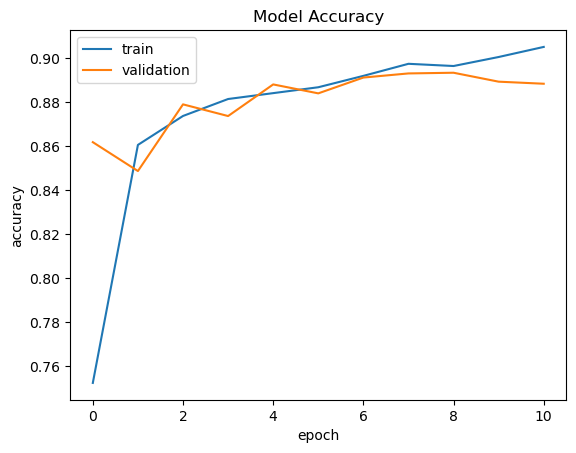

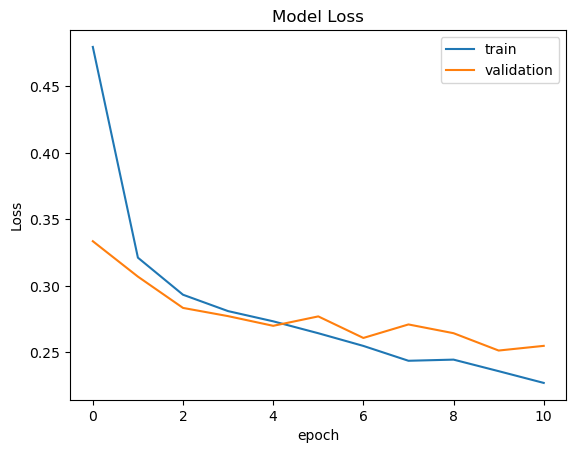

In [104]:
import matplotlib.pyplot as plt

# accuracy
plt.plot(tf_history.history["accuracy"])
plt.plot(tf_history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Model Accuracy")
plt.legend(["train","validation"])
plt.savefig("Sentiment Analysis Figures/tf_accuracy.png")
plt.show()

# loss
plt.plot(tf_history.history["loss"])
plt.plot(tf_history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(["train","validation"])
plt.savefig("Sentiment Analysis Figures/tf_loss.png")
plt.show()


### Save Model Weights

In [105]:
tf_model.save("Sentiment-analysis weights/tf_model.keras")

# DeepLearning with Pytorch

### Tokenization and Padding

In [19]:
import itertools

VOCAB_LENGTH=16000
subset_vocab=dict(itertools.islice(vocab_to_int.items(),VOCAB_LENGTH-1))
len(subset_vocab)

15999

In [20]:
def pad_sequences(reviews,vocab,max_sen_len):
    features=np.zeros((len(reviews),max_sen_len),dtype=int)
    for i, row in enumerate(reviews):
        splitted_row=row.split(" ")
        if len(splitted_row)>=max_sen_len:
            start_ind=max_sen_len
        else:
            start_ind=len(splitted_row)+1

        for j,word in enumerate(splitted_row):
            if j<max_sen_len:
                if word in vocab:
                    word_index=vocab[word]
                else:
                    # if word doesn't exist replace with zero
                    word_index=0
                features[i,-start_ind+j]=word_index
    return features

In [21]:
features_data=pad_sequences(clean_text,subset_vocab,280)

here we'll tokenize and put value of vocab on all text and pad it using post padding.

When working with `DataLoader` which is designed to work with datasets that are iterable and can be indexed. `TensorDataset` provides a convenient way to wrap tensors into dataset that can be used by `DataLoader`. So we'll first need to put our data in a `TensorDataset`.

### Train/Validation Split

In [117]:
from sklearn.model_selection import train_test_split
labels=np.array(labels)

train_x, val_x, train_y, val_y = train_test_split(
    features_data, labels,train_size=0.8, random_state=42)

train_x, val_x, train_y, val_y=np.array(train_x), np.array(val_x), np.array(train_y), np.array(val_y)

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE=50


train_data=TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
val_data=TensorDataset(torch.from_numpy(val_x),torch.from_numpy(val_y))

train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=True)

In [24]:
sample_x,sample_y=next(iter(train_loader))
print("Shape of sample is", sample_x.shape)

Shape of sample is torch.Size([50, 280])


You'll notice that PyTorch puts the batch size first then the sequence length.

In [25]:
embedding_matrix=np.zeros((VOCAB_LENGTH,300))
for word, token in subset_vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[token]=w2v_model.wv[word]

### Model Definition 

We've embedded our data manually, nd we nearly have 190,00+ words in our vocabulary. Since we're not using one-hot encoding, we'll use `nn.Embedding` layer to optimize our lookup.

In [26]:
#checking if we're training on GPU
train_on_gpu=torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU!")
else:
    print("Training on CPU!")


Training on GPU!


In [98]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentLSTM(nn.Module):
    def __init__(self, seq_length,output_size, n_layers, hidden_size,bias=True,batch_first=True ,drop_prob=0.3):
        super(SentimentLSTM,self).__init__()
        self.n_layers=n_layers
        self.seq_length=seq_length
        self.hidden_size=hidden_size
        self.batch_first=batch_first
        self.drop_prob=drop_prob
        self.bias=bias
        self.output_size=output_size

        self.embed=nn.Embedding.from_pretrained(torch.tensor(embedding_matrix),padding_idx=0)
        self.lstm=nn.LSTM(embed_vector_size,hidden_size,n_layers,dropout=drop_prob, batch_first=True,bidirectional=True)
        self.conv=nn.Conv1d(seq_length,100,kernel_size=5)
        self.pool=nn.AdaptiveAvgPool1d(100)
        self.fc1=nn.Linear(100,16)
        self.fc2=nn.Linear(16,1)

    def forward(self,x, hidden):
        x=self.embed(x)
        lstm_out,hidden=self.lstm(x.to(torch.float32))
        out=self.conv(lstm_out)
        out=self.pool(out)
        out=F.relu(self.fc1(out))
        out=self.fc2(out)

        out=out.view(BATCH_SIZE,-1)[:,-1]

        return out, hidden
    
    def init_hidden(self, batch_size):
        weight=next(self.parameters()).data
        if train_on_gpu:
            hidden=(weight.new(self.n_layers,batch_size,self.hidden_size).zero_().cuda(),
                    weight.new(self.n_layers,batch_size,self.hidden_size).zero_().cuda())
        else:
            hidden=(weight.new(self.n_layers,batch_size,self.hidden_size).zero_(),
                    weight.new(self.n_layers,batch_size,self.hidden_size).zero_())
        return hidden


    



In [99]:
seq_length=280
output_size=1
n_layers=2
hidden_size=100

rnn_model=SentimentLSTM(seq_length,output_size,n_layers,hidden_size,bias=True,batch_first=True)

In [100]:
print(rnn_model)

SentimentLSTM(
  (embed): Embedding(16000, 300, padding_idx=0)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (conv): Conv1d(280, 100, kernel_size=(5,), stride=(1,))
  (pool): AdaptiveAvgPool1d(output_size=100)
  (fc1): Linear(in_features=100, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


## Training (DL with PyTorch)

### Optimizer and Loss

In [101]:
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(rnn_model.parameters(),lr=0.001)

In [102]:
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.01,steps_per_epoch=len(train_loader),anneal_strategy="cos",epochs=20)

### Training Loop

In [103]:
import sklearn.metrics as metrics

In [104]:
num_epochs=12
clip=5
train_losses, val_losses=[],[]
train_accs, val_accs=[],[]

print_every=100

if train_on_gpu:
    rnn_model.cuda()

for epoch in range(num_epochs):
    h=rnn_model.init_hidden(BATCH_SIZE)
    rnn_model.train()
    train_acc=0
    train_loss=0
    for step,(inputs,batch_labels) in enumerate(train_loader):
        if train_on_gpu:
            inputs, batch_labels=inputs.cuda(),batch_labels.cuda()
        # 0) zero gradients
        rnn_model.zero_grad()
        # 0.1) Creating new variables for hidden state
        h= tuple([each.data for each in h])
        #1) forward pass
        output, h=rnn_model(inputs,h)
        #2) backward pass
        loss=criterion(output.squeeze(),batch_labels.float())
        loss.backward()
        train_loss+=loss.item()
        # 2.1) gradient clipping
        #nn.utils.clip_grad_norm_(rnn_model.parameters(),clip)
        #3) optimizer step
        optimizer.step()
        scheduler.step()
        # 4) measure accuracy
        probs=F.sigmoid(output)
        batch_accuracy=metrics.accuracy_score(batch_labels.cpu(),probs.cpu()>0.5)

        train_acc+=(batch_accuracy/len(train_loader))
    
    
        
        

    # 4) validation loop

    else:
        train_loss=train_loss/len(train_loader)
        train_losses.append(train_loss)
        with torch.no_grad():
            train_accs.append(train_acc)
            rnn_model.eval()
            val_acc=0
            val_loss=0
            for inputs, batch_labels in val_loader:
                if train_on_gpu:
                    inputs, batch_labels=inputs.cuda(), batch_labels.cuda()
                h=rnn_model.init_hidden(BATCH_SIZE)
                h=tuple([each.data for each in h])
                out, h= rnn_model(inputs,h)
                val_loss+=criterion(out.squeeze(), batch_labels.float())
                
                # accuracy
                probs_val=F.sigmoid(out)
                batch_accuracy=metrics.accuracy_score(batch_labels.cpu(),probs_val.cpu()>0.5)
                val_acc+=(batch_accuracy/len(val_loader))

            val_loss/=len(val_loader)
            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

            print(f"For epoch {epoch+1}/{num_epochs} "\
            f"Step {step} "
                    f"Training Loss is: {round(train_loss,3)} "\
                    f"Validation Loss is: {round(val_loss.item(),3)} "
                    f"Training Accuracy is: {round(train_acc*100,3)} "\
                    f"Validation Accuracy is: {round(val_acc*100,3)}")
            
            rnn_model.train()


    



For epoch 1/12 Step 639 Training Loss is: 0.36 Validation Loss is: 0.284 Training Accuracy is: 82.863 Validation Accuracy is: 88.575
For epoch 2/12 Step 639 Training Loss is: 0.279 Validation Loss is: 0.26 Training Accuracy is: 88.419 Validation Accuracy is: 89.587
For epoch 3/12 Step 639 Training Loss is: 0.253 Validation Loss is: 0.24 Training Accuracy is: 89.641 Validation Accuracy is: 89.987
For epoch 4/12 Step 639 Training Loss is: 0.233 Validation Loss is: 0.237 Training Accuracy is: 90.788 Validation Accuracy is: 90.2
For epoch 5/12 Step 639 Training Loss is: 0.221 Validation Loss is: 0.251 Training Accuracy is: 91.281 Validation Accuracy is: 90.425
For epoch 6/12 Step 639 Training Loss is: 0.191 Validation Loss is: 0.241 Training Accuracy is: 92.616 Validation Accuracy is: 90.687
For epoch 7/12 Step 639 Training Loss is: 0.168 Validation Loss is: 0.251 Training Accuracy is: 93.625 Validation Accuracy is: 90.525
For epoch 8/12 Step 639 Training Loss is: 0.143 Validation Loss is:

### Plotting Model Complexity

In [105]:
import matplotlib.pyplot as plt

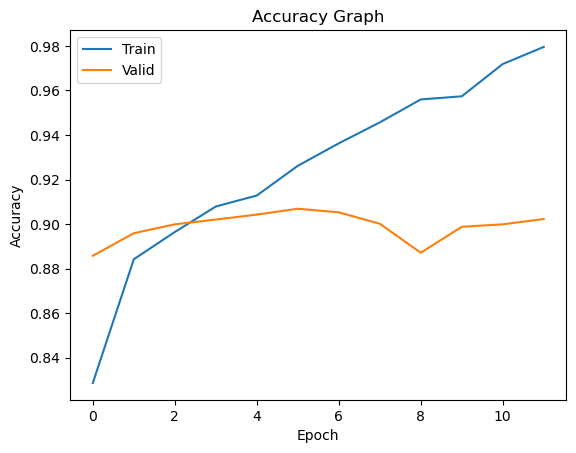

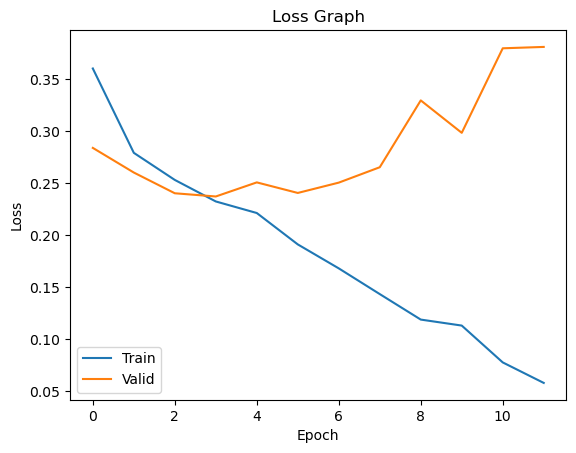

In [106]:
# accuracy
plt.plot(train_accs)
plt.plot(val_accs)
plt.title("Accuracy Graph")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train","Valid"])
plt.savefig("Sentiment Analysis Figures/torch_accuracy.jpeg")
plt.show()

# accuracy
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train","Valid"])
plt.savefig("Sentiment Analysis Figures/torch_loss.jpeg")
plt.show()

By looking at graph we should've stopped at the 5th epoch

### Saving Model

In [107]:
torch.save(rnn_model.state_dict(),"Sentiment-analysis weights/torch_weights.pth")

# Classical Approach 

### Train/Validation Split

In [153]:
train_x,val_x,train_y,val_y=train_test_split(features_data,labels,train_size=0.8)

### Model Definition

In [154]:
from sklearn import svm

In [155]:
clf=svm.LinearSVC()
clf.fit(train_x,train_y)

LinearSVC()

### Accuracy

In [158]:
from sklearn.metrics import accuracy_score,classification_report

In [157]:
y_pred=clf.predict(val_x)
accuracy=accuracy_score(y_true=val_y,y_pred=y_pred)
print(f"The accuracy of our model is {round(accuracy*100,ndigits=3)}%")

The accuracy of our model is 53.062%


The accuracy isn't that good, it might be as good as just randomly assigning labels which will yield a 50% accuracy

### Classification Report

In [159]:
print(classification_report(val_y, y_pred, target_names=['negative', 'positve']))

              precision    recall  f1-score   support

    negative       0.53      0.61      0.57      4008
     positve       0.54      0.45      0.49      3992

    accuracy                           0.53      8000
   macro avg       0.53      0.53      0.53      8000
weighted avg       0.53      0.53      0.53      8000



### Saving Model

In [161]:
import pickle
with open('Sentiment-analysis weights/linear_svm_model.pkl','wb') as f:
    pickle.dump(clf,f)